   # ML_DL_WORKSHOP

# Feature Extraction 

## Using a spacfic scripts to extract the defined features - Example 

In [ ]:
"""
> tshark -r input.pcap -T fields -E header=y -E separator=, -E quote=d -E occurrence=f \
-e ip.version -e ip.hdr_len -e ip.tos -e ip.id -e ip.flags -e ip.flags.rb -e ip.flags.df \ 
-e ip.flags.mf -e ip.frag_offset -e ip.ttl -e ip.proto -e ip.checksum -e ip.src -e ip.dst \ 
-e ip.len -e ip.dsfield -e tcp.srcport -e tcp.dstport -e tcp.seq -e tcp.ack -e tcp.len \ 
-e tcp.hdr_len -e tcp.flags -e tcp.flags.fin -e tcp.flags.syn -e tcp.flags.reset \ 
-e tcp.flags.push -e tcp.flags.ack -e tcp.flags.urg -e tcp.flags.cwr -e tcp.window_size \ 
-e tcp.checksum -e tcp.urgent_pointer -e tcp.options.mss_val > output.csv

"""

## Using available tools for net-flow extraction 

* CIC-Flowmeter

* Nf-stream

# 1- Pre-processing 

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy import stats
from scipy.stats import ks_2samp
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt
import pickle
import joblib

%matplotlib inline

In [3]:
types = {
    'dst_port': 'uint32',
    'protocol': 'uint8',
    'timestamp': 'object',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_max': 'uint16',
    'fwd_pkt_len_min': 'uint16',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_max': 'uint16',
    'bwd_pkt_len_min': 'uint16',
    'bwd_pkt_len_mean': 'float32',
    'bwd_pkt_len_std': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_mean': 'float32',
    'flow_iat_std': 'float32',
    'flow_iat_max': 'int64',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_mean': 'float32',
    'fwd_iat_std': 'float32',
    'fwd_iat_max': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_mean': 'float32',
    'bwd_iat_std': 'float32',
    'bwd_iat_max': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'bwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_urg_flags': 'uint8',
    'fwd_header_len': 'uint32',
    'bwd_header_len': 'uint32',
    'fwd_pkts_s': 'float32',
    'bwd_pkts_s': 'float32',
    'pkt_len_min': 'uint16',
    'pkt_len_max': 'uint16',
    'pkt_len_mean': 'float32',
    'pkt_len_std': 'float32',
    'pkt_len_var': 'float32',
    'fin_flag_cnt': 'uint8',
    'syn_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'cwe_flag_count': 'uint8',
    'ece_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'pkt_size_avg': 'float32',
    'fwd_seg_size_avg': 'float32',
    'bwd_seg_size_avg': 'float32',
    'fwd_byts_b_avg': 'uint8',
    'fwd_pkts_b_avg': 'uint8',
    'fwd_blk_rate_avg': 'uint8',
    'bwd_byts_b_avg': 'uint8',
    'bwd_pkts_b_avg': 'uint8',
    'bwd_blk_rate_avg': 'uint8',
    'subflow_fwd_pkts': 'uint32',
    'subflow_fwd_byts': 'uint32',
    'subflow_bwd_pkts': 'uint32',
    'subflow_bwd_byts': 'uint32',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_act_data_pkts': 'uint32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'active_std': 'float32',
    'active_max': 'uint32',
    'active_min': 'uint32',
    'idle_mean': 'float32',
    'idle_std': 'float32',
    'idle_max': 'uint64',
    'idle_min': 'uint64',
    'label': 'category'
}

In [2]:
path1 = r"E:\Juypter-files\dataset1_LOCAL_DATA\csv_files"

In [4]:
csv = glob.glob(os.path.join(path1 , '*.csv'))
df = pd.concat((pd.read_csv(f, dtype=types) for f in csv))

## 1-1 Feature Extraction 

In [5]:
#df = pd.read_csv("E:\Juypter-files\dataset1_LOCAL_DATA\csv_files\gurd_bot_02-03-2018.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097149 entries, 0 to 1048573
Data columns (total 80 columns):
 #   Column             Dtype  
---  ------             -----  
 0   dst_port           uint32 
 1   protocol           uint8  
 2   timestamp          object 
 3   flow_duration      int64  
 4   tot_fwd_pkts       uint32 
 5   tot_bwd_pkts       uint32 
 6   totlen_fwd_pkts    uint32 
 7   totlen_bwd_pkts    uint32 
 8   fwd_pkt_len_max    uint16 
 9   fwd_pkt_len_min    uint16 
 10  fwd_pkt_len_mean   float32
 11  fwd_pkt_len_std    float32
 12  bwd_pkt_len_max    uint16 
 13  bwd_pkt_len_min    uint16 
 14  bwd_pkt_len_mean   float32
 15  bwd_pkt_len_std    float32
 16  flow_byts_s        float64
 17  flow_pkts_s        float64
 18  flow_iat_mean      float32
 19  flow_iat_std       float32
 20  flow_iat_max       int64  
 21  flow_iat_min       int64  
 22  fwd_iat_tot        int64  
 23  fwd_iat_mean       float32
 24  fwd_iat_std        float32
 25  fwd_iat_max       

In [7]:
df.head()

,dst_port,protocol,timestamp,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,...,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,443,6,02/03/2018 08:47:38,141385,9,7,553,3773,202,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,49684,6,02/03/2018 08:47:38,281,2,1,38,0,38,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,443,6,02/03/2018 08:47:40,279824,11,15,1086,10527,385,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,443,6,02/03/2018 08:47:40,132,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,443,6,02/03/2018 08:47:41,274016,9,13,1285,6141,517,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [8]:
df['label'].value_counts()

Benign                      1209156
DoS attacks-Hulk             461912
Bot                          286191
DoS attacks-SlowHTTPTest     139890
Name: label, dtype: int64

# 2- Data visualization EDA - explority data analysis 

## 2-1 how to label the dataset ?

In [10]:
df['label_cat'] = df.label.astype('category').cat.codes
df['label_code'] = (df.label != 'Benign').astype('int')

In [11]:
df.head()

,dst_port,protocol,timestamp,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,...,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label,label_cat,label_code
0,443,6,02/03/2018 08:47:38,141385,9,7,553,3773,202,0,...,0.0,0,0,0.0,0.0,0,0,Benign,0,0
1,49684,6,02/03/2018 08:47:38,281,2,1,38,0,38,0,...,0.0,0,0,0.0,0.0,0,0,Benign,0,0
2,443,6,02/03/2018 08:47:40,279824,11,15,1086,10527,385,0,...,0.0,0,0,0.0,0.0,0,0,Benign,0,0
3,443,6,02/03/2018 08:47:40,132,2,0,0,0,0,0,...,0.0,0,0,0.0,0.0,0,0,Benign,0,0
4,443,6,02/03/2018 08:47:41,274016,9,13,1285,6141,517,0,...,0.0,0,0,0.0,0.0,0,0,Benign,0,0


<AxesSubplot:xlabel='count', ylabel='label'>

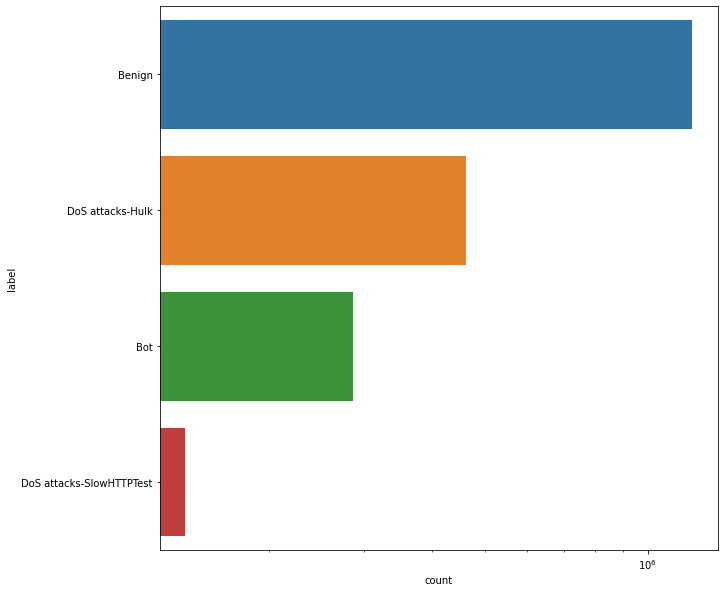

In [12]:
f, ax = plt.subplots(figsize=(10, 10)) # figure size 
ax.set(xscale='log')
# from seaborn identify label as y and dataset x is df 
sns.countplot(y='label', data=df, order = df['label'].value_counts().index, ax=ax)

In [13]:
df.groupby('label').agg({'label':'first', 'label':'count'}).rename_axis(None).sort_values('label', ascending=False)

,label
Benign,1209156
DoS attacks-Hulk,461912
Bot,286191
DoS attacks-SlowHTTPTest,139890


In [14]:
#corr = df.drop(columns=['label' , 'timestamp']).corr()

In [15]:
#plt.figure(figsize=(20, 20))

#sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, linewidths=.5, 
 #          cmap=sns.diverging_palette(620, 10, as_cmap=True))

## 1-2 Data Cleaning & prepration 

* Missing values 
* Inf values 
* feature variance 
* constant features
* outliers
* un-wanted features 
* quasi features 
* duplicated features 
* correlated features 

##  Missing value - N/A

In [16]:
[col for col in df.columns if df[col].isnull().sum()>0]

['flow_byts_s']

In [17]:
print(f"Null values of flow_byts_s: {df[df['flow_byts_s'].isnull()]['dst_port'].count()}")

Null values of flow_byts_s: 2558


##  Infinty values - inf

In [18]:
inf_col = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
inf_col

['flow_byts_s', 'flow_pkts_s']

In [19]:
print(f"Infinity values of flow_byts_s: {df[df['flow_byts_s'] == np.inf]['dst_port'].count()}")

Infinity values of flow_byts_s: 1492


In [20]:
for col in inf_col:
    df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    mean = df[col].mean()
    df[col].fillna(mean, inplace=True)

In [21]:
inf_col = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
inf_col

[]

## Negative values with mean 

In [22]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.values
numeric_cols

array(['dst_port', 'protocol', 'flow_duration', 'tot_fwd_pkts',
       'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts',
       'fwd_pkt_len_max', 'fwd_pkt_len_min', 'fwd_pkt_len_mean',
       'fwd_pkt_len_std', 'bwd_pkt_len_max', 'bwd_pkt_len_min',
       'bwd_pkt_len_mean', 'bwd_pkt_len_std', 'flow_byts_s',
       'flow_pkts_s', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max',
       'flow_iat_min', 'fwd_iat_tot', 'fwd_iat_mean', 'fwd_iat_std',
       'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_tot', 'bwd_iat_mean',
       'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags',
       'bwd_psh_flags', 'fwd_urg_flags', 'bwd_urg_flags',
       'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s', 'bwd_pkts_s',
       'pkt_len_min', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_std',
       'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt', 'rst_flag_cnt',
       'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt', 'cwe_flag_count',
       'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
       'fwd_

In [23]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.values
columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]

In [24]:
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)

In [25]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.values

columns

['init_fwd_win_byts', 'init_bwd_win_byts']

# train and test data 

## Feature variance 

In [26]:
X = df.drop(columns=['label', 'label_code' , 'label_cat'])
y = df[['label_code', 'label_cat',  'label']]

In [27]:
stats = X.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index

pd.Series(features_no_variance).sort_values()

9    bwd_blk_rate_avg
7      bwd_byts_b_avg
8      bwd_pkts_b_avg
0       bwd_psh_flags
2       bwd_urg_flags
3      cwe_flag_count
6    fwd_blk_rate_avg
4      fwd_byts_b_avg
5      fwd_pkts_b_avg
1       fwd_urg_flags
dtype: object

In [28]:
#then drop features with variance below threshold
X = X.drop(columns=features_no_variance)

# Un-wanted features

In [29]:
X = X.drop(columns=['timestamp', 'dst_port'])

##  Constant features 

In [30]:
const_features = [f for f in X.columns if X[f].std() == 0]

In [31]:
len(const_features)

0

##  Quasi constant features

In [32]:
#quasiModel=VarianceThreshold(threshold=0.01)
#quasiModel.fit(X)

In [33]:
#quasiArr=quasiModel.get_support()
#quasiArr

In [34]:
#collections.Counter(quasiArr)

In [35]:
#quasiCols=[col for col in X.columns if col not in X.columns[quasiArr]]
#quasiCols

In [36]:
#print('Shape before drop-->',df.shape)
#df.drop(columns=quasiCols,axis=1,inplace=True)
#print('Shape after drop-->',df.shape)

##  Duplicate features

In [37]:
#unique_features = X.drop_duplicates(keep='first').T
#unique_features.shape

In [38]:
#X.shape

##  Correlated features

In [39]:
cluster_threshold = 1

corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)


<AxesSubplot:>

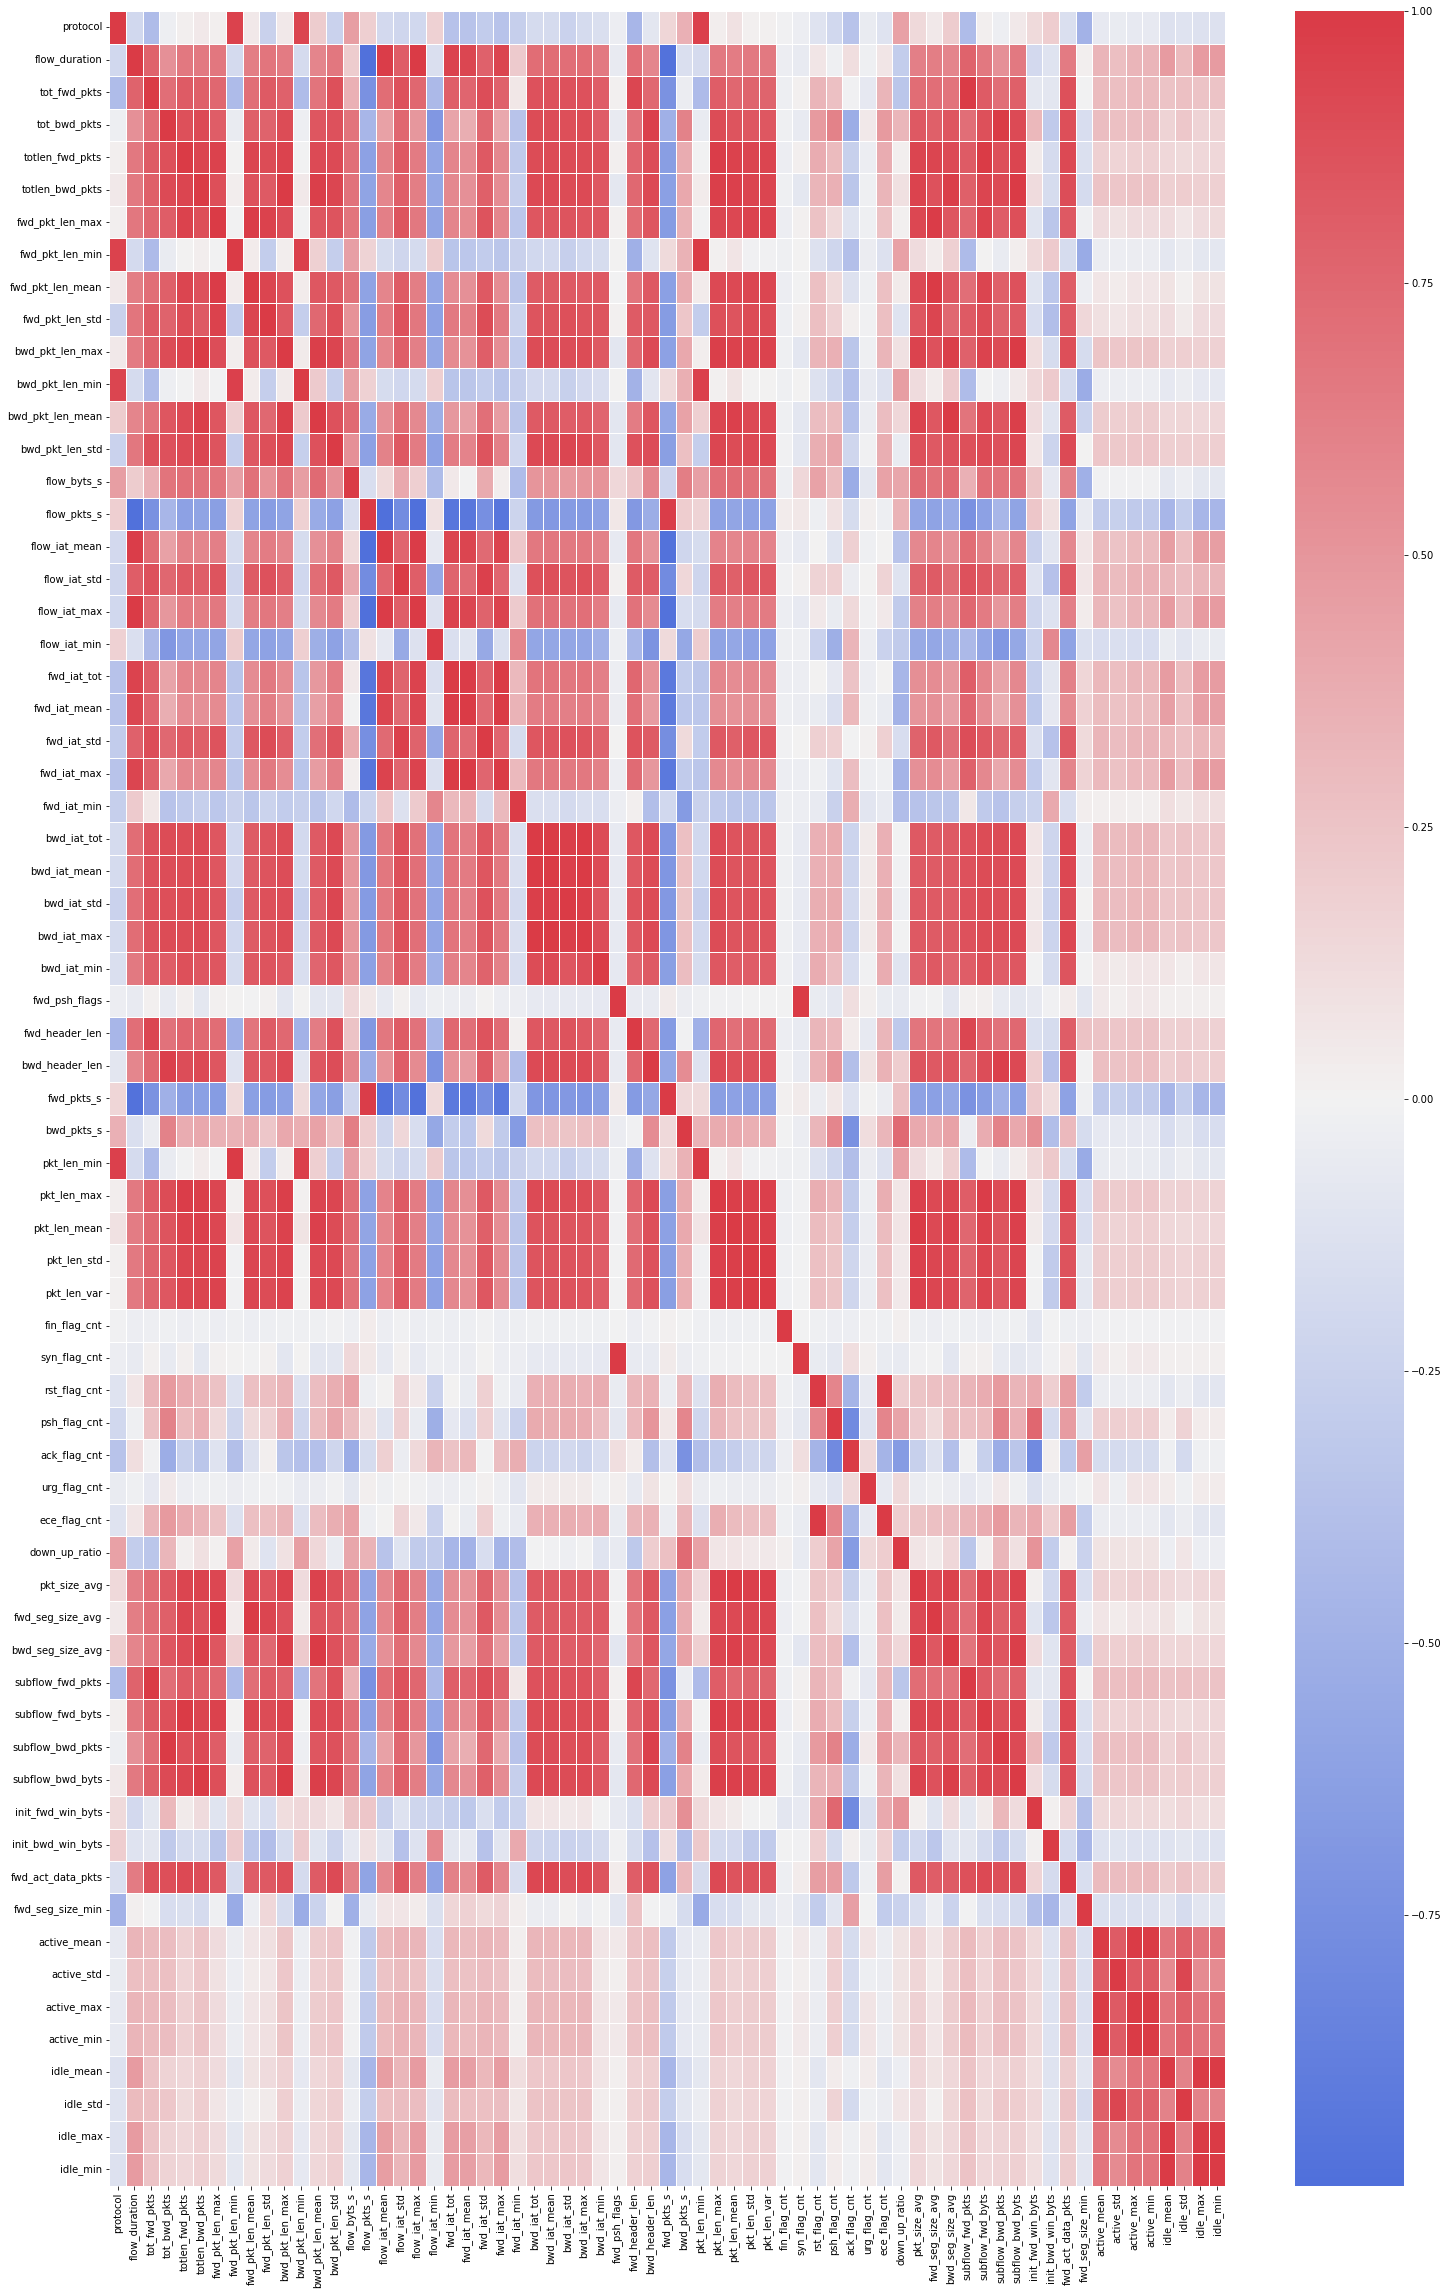

In [40]:
fig = plt.subplots(figsize=(25, 40))

sns.heatmap(corr, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True))

In [41]:
cluster_ids = hierarchy.fcluster(corr_linkage, cluster_threshold, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

selected_features = X.columns[selected_features].tolist()

print('Selected features:')
pd.Series(selected_features)

Selected features:


0              protocol
1         flow_duration
2          tot_fwd_pkts
3          tot_bwd_pkts
4       totlen_fwd_pkts
5       fwd_pkt_len_max
6       fwd_pkt_len_std
7      bwd_pkt_len_mean
8       bwd_pkt_len_std
9           flow_byts_s
10          flow_pkts_s
11         flow_iat_std
12         flow_iat_min
13          fwd_iat_tot
14          fwd_iat_min
15        fwd_psh_flags
16           bwd_pkts_s
17         fin_flag_cnt
18         rst_flag_cnt
19         psh_flag_cnt
20         ack_flag_cnt
21         urg_flag_cnt
22        down_up_ratio
23    init_fwd_win_byts
24    init_bwd_win_byts
25     fwd_seg_size_min
26          active_mean
27            idle_mean
dtype: object

In [42]:
X = X[selected_features]

## Outlier detection using Z-score

# 3- Training and Testing 

In [43]:
y.head()

,label_code,label_cat,label
0,0,0,Benign
1,0,0,Benign
2,0,0,Benign
3,0,0,Benign
4,0,0,Benign


# 3- 1 Dataset Split

In [44]:
def print_report(ds_type, cls, X_vals, y_true, y_predict, plot_pr=False, plot_roc=False):
    print(f"Classification Report ({ds_type}):")
    print(classification_report(y_true, y_predict))
    print(f"Avg Precision Score: {average_precision_score(y_true, y_predict, average='weighted')}")
    
    if plot_roc:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_predict)}")
        skplt.metrics.plot_roc(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    if plot_pr:
        
        skplt.metrics.plot_precision_recall(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    print('\n')

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y , test_size=0.2  ,random_state=100, stratify=y.label_code)

In [46]:
X_train_h= pd.get_dummies(X_train, columns=['protocol'])
X_test_h= pd.get_dummies(X_test, columns=['protocol'])
5 2 3

In [70]:
X_test_h.head()

,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,fwd_pkt_len_max,fwd_pkt_len_std,bwd_pkt_len_mean,bwd_pkt_len_std,flow_byts_s,flow_pkts_s,...,urg_flag_cnt,down_up_ratio,init_fwd_win_byts,init_bwd_win_byts,fwd_seg_size_min,active_mean,idle_mean,protocol_0,protocol_6,protocol_17
66750,612,2,0,0,0,0.000000,0.000000,0.000000,0.000000,3267.973856,...,0,0,2052.000000,10382.735301,20,0.0,0.0,0,1,0
710745,103,2,1,0,0,0.000000,0.000000,0.000000,0.000000,29126.213590,...,1,0,237.000000,255.000000,20,0.0,0.0,0,1,0
462317,4587327,5,3,935,935,418.144714,101.666664,176.091827,270.309921,1.743935,...,0,0,237.000000,211.000000,32,0.0,0.0,0,1,0
597376,318,1,1,36,36,0.000000,52.000000,0.000000,276729.559700,6289.308176,...,0,1,6171.611285,10382.735301,8,0.0,0.0,0,0,1
159614,5492114,5,4,935,935,418.144714,171.500000,198.031143,295.150465,1.638713,...,0,0,219.000000,211.000000,32,0.0,5160925.0,0,1,0


In [48]:
y.label.value_counts()

Benign                      1209156
DoS attacks-Hulk             461912
Bot                          286191
DoS attacks-SlowHTTPTest     139890
Name: label, dtype: int64

In [49]:
y_train.label.value_counts()

Benign                      967325
DoS attacks-Hulk            369565
Bot                         228811
DoS attacks-SlowHTTPTest    112018
Name: label, dtype: int64

In [50]:
y_test.label.value_counts()

Benign                      241831
DoS attacks-Hulk             92347
Bot                          57380
DoS attacks-SlowHTTPTest     27872
Name: label, dtype: int64

In [51]:
y['label_code'].value_counts()

0    1209156
1     887993
Name: label_code, dtype: int64

## 3-2 Training 

## logestic regression 

In [52]:
scaler = StandardScaler()
scaler.fit(X_train_h)

StandardScaler()

In [53]:
cls_lr = LogisticRegression(solver='saga', n_jobs=-1, verbose=2)

cls_lr.fit(scaler.transform(X_train_h), y_train.label_code)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 106 seconds


E:\ProgramDATA\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.8min finished


LogisticRegression(n_jobs=-1, solver='saga', verbose=2)

In [54]:
print_report('Train', cls_lr, scaler.transform(X_train_h), y_train.label_code, cls_lr.predict(scaler.transform(X_train_h)))

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.99      0.93      0.96    967325
           1       0.91      0.99      0.95    710394

    accuracy                           0.96   1677719
   macro avg       0.95      0.96      0.96   1677719
weighted avg       0.96      0.96      0.96   1677719

Avg Precision Score: 0.9069869432629859




Classification Report (TEST):
              precision    recall  f1-score   support

           0       0.99      0.93      0.96    241831
           1       0.91      0.99      0.95    177599

    accuracy                           0.96    419430
   macro avg       0.95      0.96      0.95    419430
weighted avg       0.96      0.96      0.96    419430

Avg Precision Score: 0.9065314716114438


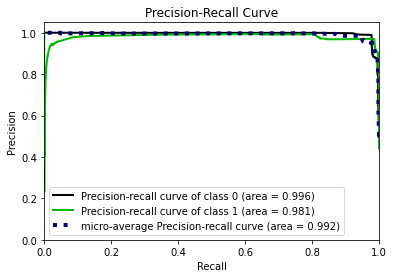

In [55]:
print_report('TEST', cls_lr, scaler.transform(X_test_h), y_test.label_code, cls_lr.predict(scaler.transform(X_test_h)), plot_pr=True)

In [64]:
# save the model to disk
filename = 'finalized_lr_model.sav'
pickle.dump(cls_lr, open(filename, 'wb'))
 
    #later
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)

## random forest 

In [57]:
cls_forest = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')

In [58]:
cls_forest.fit(X_train_h, y_train.label_code)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, verbose=1)

In [59]:
print_report('Train', cls_forest, X_train_h, y_train.label_code, cls_forest.predict(X_train_h))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    2.7s finished


Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    967325
           1       1.00      1.00      1.00    710394

    accuracy                           1.00   1677719
   macro avg       1.00      1.00      1.00   1677719
weighted avg       1.00      1.00      1.00   1677719

Avg Precision Score: 0.9998129783300705




[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished


Classification Report (test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    241831
           1       1.00      1.00      1.00    177599

    accuracy                           1.00    419430
   macro avg       1.00      1.00      1.00    419430
weighted avg       1.00      1.00      1.00    419430

Avg Precision Score: 0.9996311071807324


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished


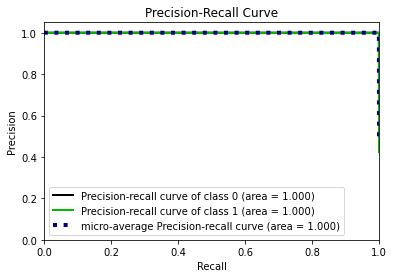

In [60]:
print_report('test', cls_forest, X_test_h, y_test.label_code, cls_forest.predict(X_test_h), plot_pr=True)

In [69]:
# loading the training and testing models 

joblib.dump(cls_forest, 'cls_forest.pkl') 

#cls = joblib.load('rf-model.pkl')

['cls_forest.pkl']

## 3-5 Hypermeter optimazation 